# Facial Emotion Recognition Using CNN

This notebook demonstrates how to train a Convolutional Neural Network (CNN) for Facial Emotion Recognition using a folder-based dataset structure. 

The data is organized into separate directories for training and testing, with each class (emotion) in its own subfolder. Keras's `flow_from_directory` utility will be used to load and label images automatically.




In [4]:
#%pip install --upgrade numpy pandas matplotlib opencv-python seaborn tensorflow scikit-learn

Importing Libraries


In [5]:
#%pip uninstall tensorflow -y
#%pip install --upgrade pip
#%pip install tensorflow==2.10.1


In [6]:
#%pip install numpy==1.24.4 --force-reinstall

In [7]:
# import tensorflow as tf
# print("Built with CUDA:", tf.test.is_built_with_cuda())
# print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split

import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available: 1


Define Paths & Hyperparameters

In [9]:
# Define dataset paths (adjust these paths if necessary)
train_dir = 'Data/train'
test_dir = 'Data/test'

# Hyperparameters
IMG_HEIGHT = 48
IMG_WIDTH = 48
BATCH_SIZE = 64
EPOCHS = 30


Create ImageDataGenerators

In [10]:
# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,    # Use 20% of train data as validation
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

# For the validation subset
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# For the test set (no data augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches from the train_dir
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',        # If your images are grayscale; otherwise use 'rgb'
    class_mode='categorical',
    subset='training',             # Set as training data
    shuffle=True
)

# Flow validation images in batches from the train_dir
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',           # Set as validation data
    shuffle=True
)

# Flow test images in batches from the test_dir
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False  # Typically set to False for test/evaluation
)

print("\nClass indices (label mapping):", train_generator.class_indices)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.

Class indices (label mapping): {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Baseline CNN Model

We'll build a simple CNN architecture with:
- Several convolutional layers with batch normalization.
- Pooling and dropout for regularization.
- Fully connected layers to output the final emotion classes.

Build & Compile the Model

In [11]:
num_classes = len(train_generator.class_indices)  # Should be 7 for FER classes

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 64)       2

Train the Model

In [12]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


Epoch 1/30
359/359 [==============================] - 48s 96ms/step - loss: 1.8748 - accuracy: 0.2631 - val_loss: 2.4651 - val_accuracy: 0.2153
Epoch 2/30
359/359 [==============================] - 18s 50ms/step - loss: 1.6632 - accuracy: 0.3432 - val_loss: 1.5784 - val_accuracy: 0.3968
Epoch 3/30
359/359 [==============================] - 18s 51ms/step - loss: 1.5905 - accuracy: 0.3768 - val_loss: 1.5067 - val_accuracy: 0.4123
Epoch 4/30
359/359 [==============================] - 18s 51ms/step - loss: 1.5390 - accuracy: 0.4030 - val_loss: 1.5252 - val_accuracy: 0.4177
Epoch 5/30
359/359 [==============================] - 18s 50ms/step - loss: 1.4977 - accuracy: 0.4188 - val_loss: 1.4165 - val_accuracy: 0.4508
Epoch 6/30
359/359 [==============================] - 18s 49ms/step - loss: 1.4611 - accuracy: 0.4370 - val_loss: 1.3580 - val_accuracy: 0.4727
Epoch 7/30
359/359 [==============================] - 17s 49ms/step - loss: 1.4341 - accuracy: 0.4505 - val_loss: 1.3391 - val_accuracy:

Visualize Training History

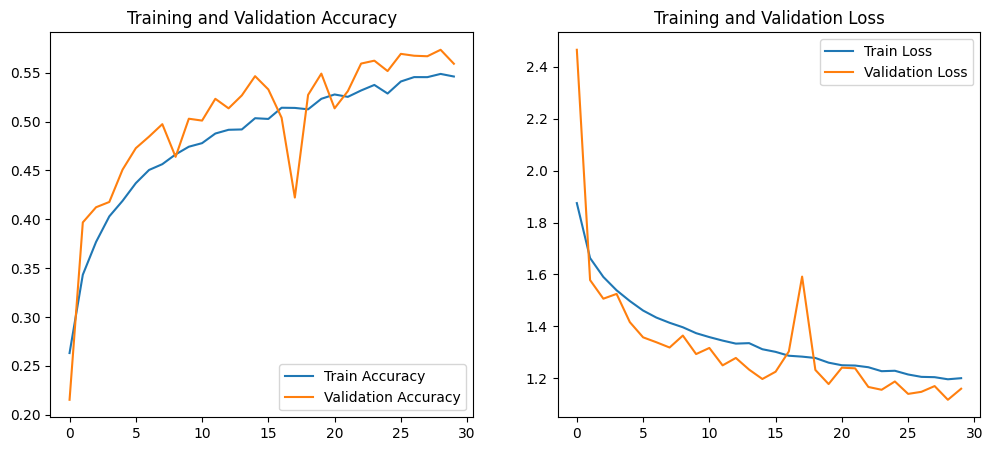

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


113/113 [==============================] - 6s 49ms/step - loss: 1.1475 - accuracy: 0.5661
Test Loss: 1.1475
Test Accuracy: 0.5661


In [15]:


# Invert the class_indices dictionary to map class IDs -> class names
class_labels = {v: k for k, v in train_generator.class_indices.items()}

def classify_image(model, img_path):
    """
    Loads a single image, preprocesses it, and returns the predicted class label along with the image array.
    """
    # 1. Load image with the same target size used in training
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    
    # 2. Convert image to array
    x = img_to_array(img)
    
    # 3. Scale pixel values
    x = x / 255.0
    
    # 4. Add batch dimension
    x_expanded = np.expand_dims(x, axis=0)
    
    # 5. Predict
    preds = model.predict(x_expanded)
    predicted_class_index = np.argmax(preds, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    
    return predicted_class_label, x

# Example usage:
test_image_path = 'my_image2.jpg'  # Replace with the actual path to your image
if os.path.exists(test_image_path):
    prediction, img_array = classify_image(model, test_image_path)
    print(f"Predicted Emotion: {prediction}")
    
    # Display the image using matplotlib
    plt.figure(figsize=(4,4))
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title(f"Prediction: {prediction}")
    plt.axis('off')
    plt.show()
else:
    print(f"File '{test_image_path}' does not exist. Please provide a valid image path.")


File 'my_image2.jpg' does not exist. Please provide a valid image path.
